In [1]:
import matplotlib.pyplot as plt
from matplotlib import figure 
import tensorflow as tf
import numpy as np
import time
import seaborn as sns
# Dependency imports
import matplotlib
import tensorflow_probability as tfp
%matplotlib inline

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, _y_train), (X_test, _y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

X_train = X_train[:10000]
_y_train = _y_train[:10000]
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=-1)
num_classes = len(np.unique(_y_test))
y_test = tf.keras.backend.one_hot(_y_test, num_classes) 
y_train = tf.keras.backend.one_hot(_y_train, num_classes)

#we can use this for regression
_y_test = np.array([_y_test]).T
_y_train = np.array([_y_train]).T

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
def build_cnn(input_shape):
    
    ##model building
    model_in = tf.keras.layers.Input(shape=input_shape)
    #32 convolution filters used each of size 3x3
    conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape)(model_in)
    #convolutional layer with rectified linear unit activation
    #64 convolution filters used each of size 3x3
    conv_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(conv_1)
    #choose the best features via pooling
    max_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
    #randomly turn neurons on and off to improve convergence
    drop_1 = tf.keras.layers.Dropout(0.25)(max_1)
    #flatten since too many dimensions, we only want a classification output
    flat_1 = tf.keras.layers.Flatten()(drop_1)
    #fully connected to get all relevant data
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(flat_1)
    #one more dropout for convergence' sake :) 
    drop_2 = tf.keras.layers.Dropout(0.5)(dense_1)
    #output a softmax to squash the matrix into output probabilities
    model_out = tf.keras.layers.Dense(10, activation='softmax')(drop_2)
    model = tf.keras.Model(model_in, model_out)
    return model

def build_bayesian_bcnn_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                    padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(10, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

def build_bayesian_bcnn_reg_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                    padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(1, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

"""
this is our loss function: a sum of KL Divergence and Softmax crossentropy
We use the @tf.function annotation becuase of TF2.0, and need no placeholders
we get each loss and return its mean
"""

@tf.function
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

"""
this is our train step with tf2.0, very ellegant:
We do our flow of the tensors over the model recording its gradientes
Then, our gradient tape to give us a list of the gradients of each parameter in relation of the loss
we dan ask our previously instanced optimizer to apply those gradients to the variable
It is cool to see that it works even with TensorFlow probability- probabilistic layers parameters
"""
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = bcnn(X_train)
        loss = elbo_loss(labels, logits)
    gradients = tape.gradient(loss, bcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, bcnn.trainable_variables))
    return loss

def accuracy(preds, labels):
    return np.mean(np.argmax(preds, axis=1) == np.argmax(labels, axis=1))

"""
plotting tools
"""
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, \
                   med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()

In [6]:
#here we build the network, instance an optizmier and compile it
cnn = build_cnn(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)
cnn.compile(loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'], optimizer=optimizer)

history = cnn.fit(X_train, _y_train, epochs=20, validation_split=0.1)

Epoch 1/20
282/282 [==============================] - 2s 7ms/step - loss: 0.4757 - accuracy: 0.8548 - val_loss: 0.1554 - val_accuracy: 0.9540
Epoch 2/20
282/282 [==============================] - 2s 5ms/step - loss: 0.2459 - accuracy: 0.9268 - val_loss: 0.1386 - val_accuracy: 0.9620
Epoch 3/20
282/282 [==============================] - 2s 5ms/step - loss: 0.2079 - accuracy: 0.9399 - val_loss: 0.1439 - val_accuracy: 0.9660
Epoch 4/20
282/282 [==============================] - 2s 5ms/step - loss: 0.1907 - accuracy: 0.9444 - val_loss: 0.1154 - val_accuracy: 0.9640
Epoch 5/20
282/282 [==============================] - 2s 5ms/step - loss: 0.1737 - accuracy: 0.9457 - val_loss: 0.1090 - val_accuracy: 0.9700
Epoch 6/20
282/282 [==============================] - 2s 5ms/step - loss: 0.1617 - accuracy: 0.9510 - val_loss: 0.1083 - val_accuracy: 0.9750
Epoch 7/20
282/282 [==============================] - 2s 5ms/step - loss: 0.1407 - accuracy: 0.9553 - val_loss: 0.1317 - val_accuracy: 0.9650
Epoch 

In [7]:
bcnn = build_bayesian_bcnn_model(X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=0.01)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [9]:
"""
in our train step we can see that it lasts more tha na normal CNN to converge
on the other side, we can have the confidence interval for our predictions, which are 
wonderful in terms of taking sensitive predictions
"""
#times = []
accs = []
val_accs = []
losses = []
val_losses = []
epochs = 35
for i in range(epochs):
    #tic = time.time()
    loss = train_step(X_train, y_train)
    preds = bcnn(X_train)
    acc = accuracy(preds, y_train)
    accs.append(acc)
    losses.append(loss)
    
    val_preds = bcnn(X_test)
    val_loss = elbo_loss(y_test, val_preds)
    val_acc = accuracy(y_test, val_preds)
    
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    #tac = time.time()
    #train_time = tac-tic
    #times.append(train_time)
    #print("Epoch: {}: loss = {:7.3f} , accuracy = {:7.3f}, val_loss = {:7.3f}, val_acc={:7.3f} time: {:7.3f}".format(i, loss, acc, val_loss, val_acc, train_time))
    print(f"Epoch {i}:loss={loss:.3f},accuracy={acc:.3f},val_loss={val_loss:.3f},val_acc={val_acc:.3f}")

Epoch 0:loss=0.211,accuracy=0.942,val_loss=0.235,val_acc=0.927
Epoch 1:loss=0.197,accuracy=0.943,val_loss=0.239,val_acc=0.928
Epoch 2:loss=0.202,accuracy=0.946,val_loss=0.230,val_acc=0.932
Epoch 3:loss=0.182,accuracy=0.947,val_loss=0.215,val_acc=0.935
Epoch 4:loss=0.179,accuracy=0.948,val_loss=0.212,val_acc=0.936
Epoch 5:loss=0.178,accuracy=0.953,val_loss=0.204,val_acc=0.941
Epoch 6:loss=0.161,accuracy=0.954,val_loss=0.196,val_acc=0.941
Epoch 7:loss=0.150,accuracy=0.958,val_loss=0.187,val_acc=0.943
Epoch 8:loss=0.141,accuracy=0.957,val_loss=0.179,val_acc=0.946
Epoch 9:loss=0.140,accuracy=0.963,val_loss=0.171,val_acc=0.947
Epoch 10:loss=0.130,accuracy=0.963,val_loss=0.171,val_acc=0.949
Epoch 11:loss=0.121,accuracy=0.964,val_loss=0.165,val_acc=0.950
Epoch 12:loss=0.118,accuracy=0.966,val_loss=0.164,val_acc=0.951
Epoch 13:loss=0.115,accuracy=0.965,val_loss=0.159,val_acc=0.950
Epoch 14:loss=0.101,accuracy=0.968,val_loss=0.154,val_acc=0.953
Epoch 15:loss=0.101,accuracy=0.967,val_loss=0.156,

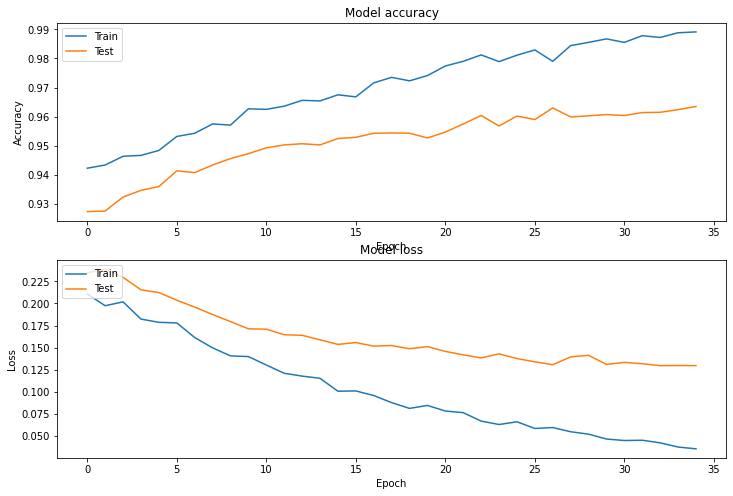

In [15]:
#plotting accuracy
f, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(np.array(accs), label="acc")
ax[0].plot(np.array(val_accs), label="val_acc")
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax[1].plot(np.array(losses), label="loss")
ax[1].plot(np.array(val_losses), label="val_loss")
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')

In [7]:
from keras import callbacks, optimizers
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer


#okay now try for regression
def build_bayesian_regression_model(input_shape):
    
    """
    Here we use tf.keras.Model to use our graph as a Neural Network:
    We select our input node as the net input, and the last node as our output (predict node).
    Note that our model won't be compiled, as we are usign TF2.0 and will optimize it with
    a custom @tf.function for loss and a @tf.function for train_step
    Our input parameter is just the input shape, a tuple, for the input layer
    """
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    conv_1 = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3),\
                                                    padding="same", strides=2)
    x = conv_1(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    conv_2 = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)
    x = conv_2(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Flatten()(x)
    dense_1 = tfp.python.layers.DenseFlipout(512, activation='relu')
    x = dense_1(x)
    dense_2 = tfp.python.layers.DenseFlipout(1, activation=None)
    model_out = dense_2(x)  # logits
    model = tf.keras.Model(model_in, model_out)
    return model

def neg_log_likelihood(y_obs, y_pred, sigma=1.0):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))
    
train_size = 32
batch_size = train_size
num_batches = train_size / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 1.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

In [56]:
n_mc_run = 1000
med_prob_thres = 0.20

y_pred_logits_list = [bcnn(X_test) for _ in range(n_mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_logits_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_testid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_testid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',\
      sum(np.equal(np.argmax(y_test[idx_testid],axis=-1),\
                   np.argmax(y_pred[idx_testid],axis=-1)))/len(y_test[idx_testid]))

print('Test accuracy on MNIST (unrecognizable samples):',\
      sum(np.equal(np.argmax(y_test[idx_invalid],axis=-1),\
                   np.argmax(y_pred[idx_invalid],axis=-1)))/len(y_test[idx_invalid]))

Number of recognizable samples: 9997
Unrecognizable samples: [1039 1969 5735]


OverflowError: Python int too large to convert to C long

True label of the test sample 0: 9


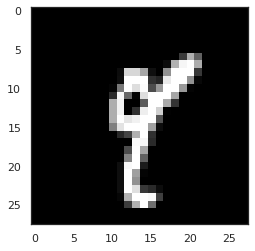

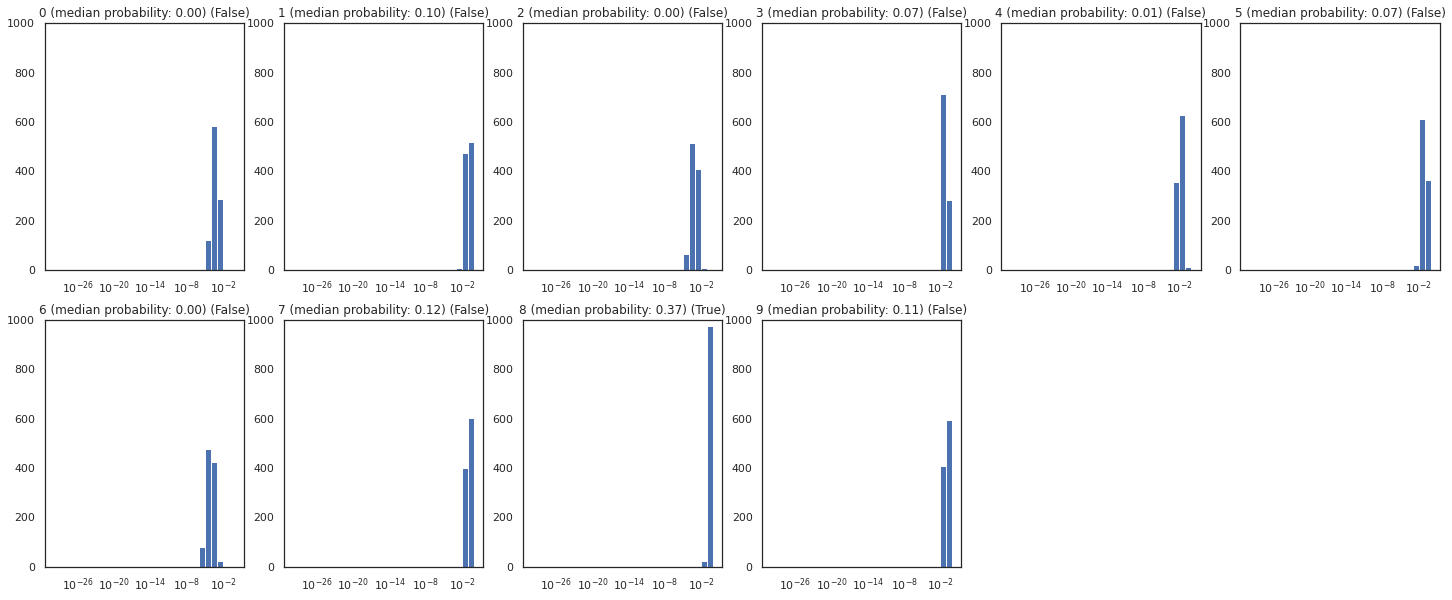

In [57]:
class_nmr = 10
#i = 3030 
i = 4761
plt.imshow(X_test[i, :, :, 0], cmap='gist_gray')
print("True label of the test sample {}: {}".format(0, np.argmax(y_test[i], axis=-1)))

plot_pred_hist(y_pred_prob_all[i], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may w

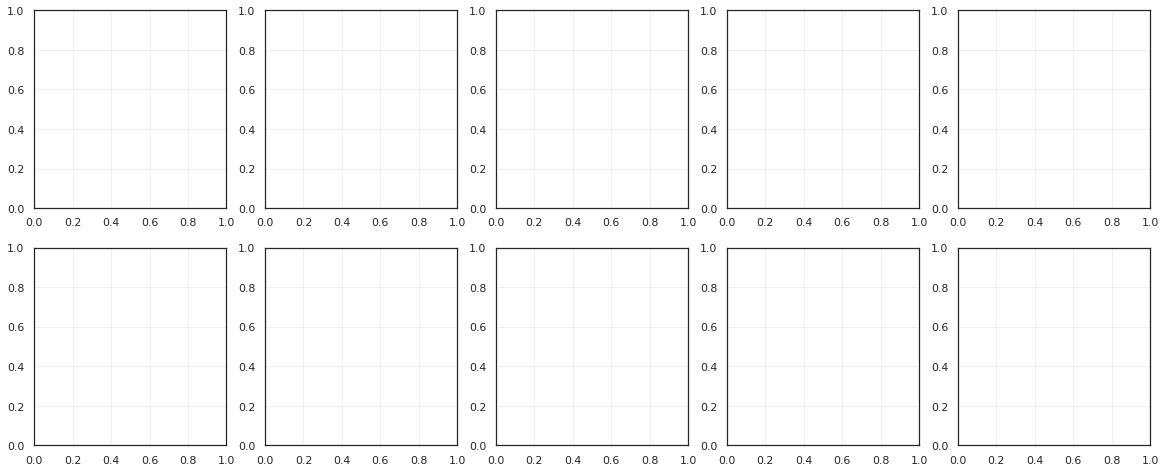

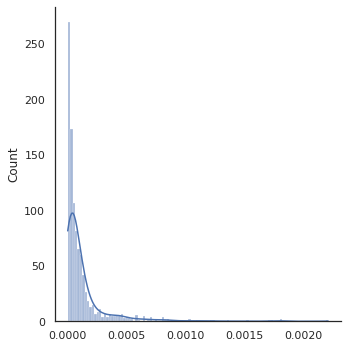

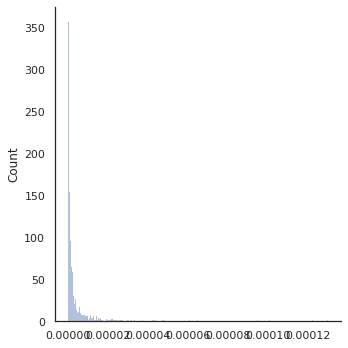

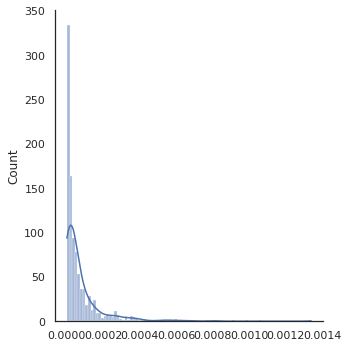

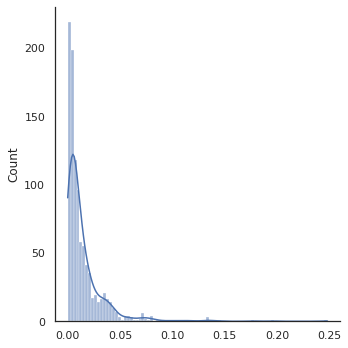

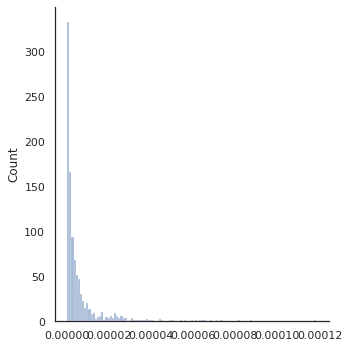

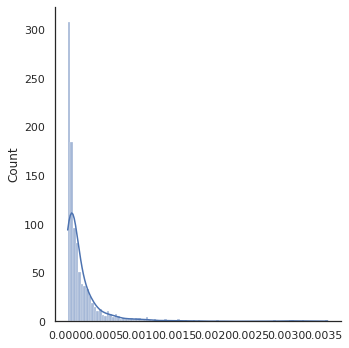

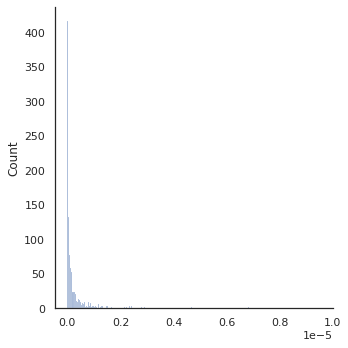

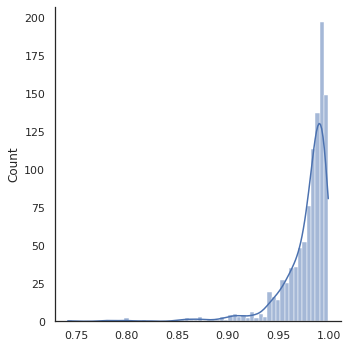

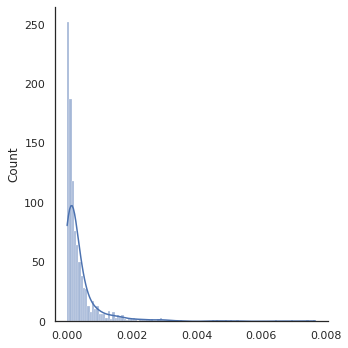

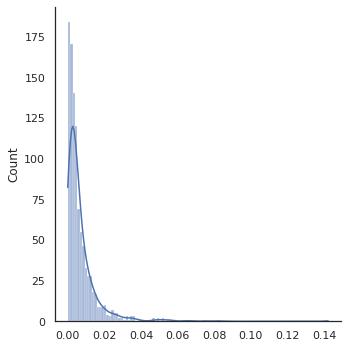

In [58]:
i=0
fig, axes = plt.subplots(2,5, figsize=(20,8))
for yhat, ax  in zip(y_pred_prob_all[i], axes.flatten()):
    sns.displot(yhat,ax=ax, stat="count", kde=True)
    ax.grid(alpha=0.3)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


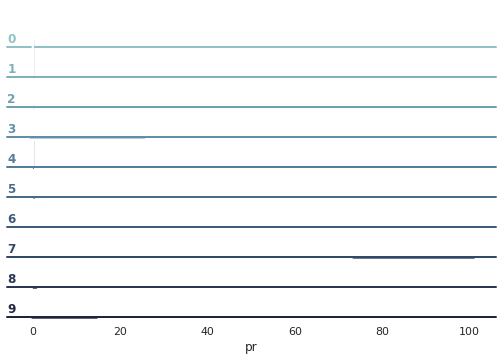

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
i = 0
# Create the data
pr = pd.DataFrame(y_pred_prob_all[i]).stack().values*100
#label = np.tile(list("0123456789"),n_mc_run)
label = np.array(list('0123456789')).repeat(n_mc_run)
df = pd.DataFrame()
df['pr']=pr
df['label']=label

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="label", hue="label", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "pr",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, common_norm=True)
g.map(sns.kdeplot, "pr", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "pr")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

<AxesSubplot:>

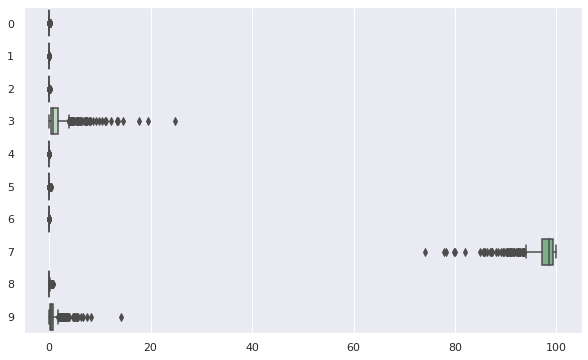

In [70]:
import numpy as np
import seaborn as sns

sns.set_theme()
# Create a random dataset across several variables
# Show each distribution with both violins and points
i=0
ds = pd.DataFrame(y_pred_prob_all[i])*100
d = ds.values.T
f, ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=d, palette="light:g", orient="h", ax=ax)
#sns.violinplot(data=d, palette="light:g", inner="points", orient="h")

In [69]:
#seems like the boxplot method is the best way as the facet method seems faulty

In [ ]:
#so we can play with the thresholds here and set a threshold that really discerns 
#or we have no threshold and just present the distribution after n number or runs
#since the model is just sampling from a stochastic distribution of a mean and std
#we can say how many runs of the model do we get?